In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import mean_absolute_error

In [3]:
from darts import TimeSeries
from darts.models import AutoARIMA, LightGBMModel

In [4]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set(font_scale=1.25)

In [5]:
##############################################################################################################################################################################################

In [6]:
data = pd.read_csv("train.csv")

In [7]:
train = pd.DataFrame()
train["Unit"] = data["БЕ"]
train["Date"] = data["Дата транзакции"]
train["RUB"] = data["Сумма в RUB"]

In [8]:
train_0 = train[train["Unit"]==0][["Date", "RUB"]]
train_0.set_index(pd.to_datetime(train_0["Date"]), inplace=True)
train_0.drop(["Date"], inplace=True, axis=1)

train_1 = train[train["Unit"]==1][["Date", "RUB"]]
train_1.set_index(pd.to_datetime(train_1["Date"]), inplace=True)
train_1.drop(["Date"], inplace=True, axis=1)

train_2 = train[train["Unit"]==2][["Date", "RUB"]]
train_2.set_index(pd.to_datetime(train_2["Date"]), inplace=True)
train_2.drop(["Date"], inplace=True, axis=1)

train_3 = train[train["Unit"]==3][["Date", "RUB"]]
train_3.set_index(pd.to_datetime(train_3["Date"]), inplace=True)
train_3.drop(["Date"], inplace=True, axis=1)

train_4 = train[train["Unit"]==4][["Date", "RUB"]]
train_4.set_index(pd.to_datetime(train_4["Date"]), inplace=True)
train_4.drop(["Date"], inplace=True, axis=1)

train_5 = train[train["Unit"]==5][["Date", "RUB"]]
train_5.set_index(pd.to_datetime(train_5["Date"]), inplace=True)
train_5.drop(["Date"], inplace=True, axis=1)

train_6 = train[train["Unit"]==6][["Date", "RUB"]]
train_6.set_index(pd.to_datetime(train_6["Date"]), inplace=True)
train_6.drop(["Date"], inplace=True, axis=1)

In [9]:
train_3_1d = train_3.resample('1D').sum()

In [10]:
train_3_1d["RUB"].loc["2020-03-11":].nsmallest(10) # Платежные дни - пятница И ПОНЕДЕЛЬНИК

Date
2020-08-21   -1.140022e+08
2020-11-23   -9.864234e+07
2020-12-21   -9.853422e+07
2020-09-21   -9.648269e+07
2020-10-21   -9.631783e+07
2020-05-21   -9.309315e+07
2020-04-21   -9.185737e+07
2020-06-22   -9.125611e+07
2020-03-23   -9.104297e+07
2020-07-21   -8.594993e+07
Name: RUB, dtype: float64

In [ ]:
# Решение выше в предикт не вошло, не видит платежных пиков

In [11]:
# AUTOArima

In [12]:
# Пятница 19104602.689707343 train_3_7d = train_3.reset_index().groupby(pd.Grouper(key='Date', freq='7D', how='sum', closed='left')).sum()
# Понедельник 19360856.195185773
train_3_7d = train_3.reset_index().groupby(pd.Grouper(key='Date', freq='7D', how='sum', closed='left')).sum()

In [13]:
train_3_7d_reindex = train_3_7d.reset_index(inplace=False)

In [14]:
series_7d = TimeSeries.from_dataframe(train_3_7d_reindex, time_col='Date', value_cols='RUB', freq='7d', fill_missing_dates=True)

In [15]:
train_7d_split, val_7d_split = series_7d.split_before(0.80)

In [16]:
model7d = AutoARIMA()
model7d.fit(train_7d_split)
prediction7d = model7d.predict(len(val_7d_split))

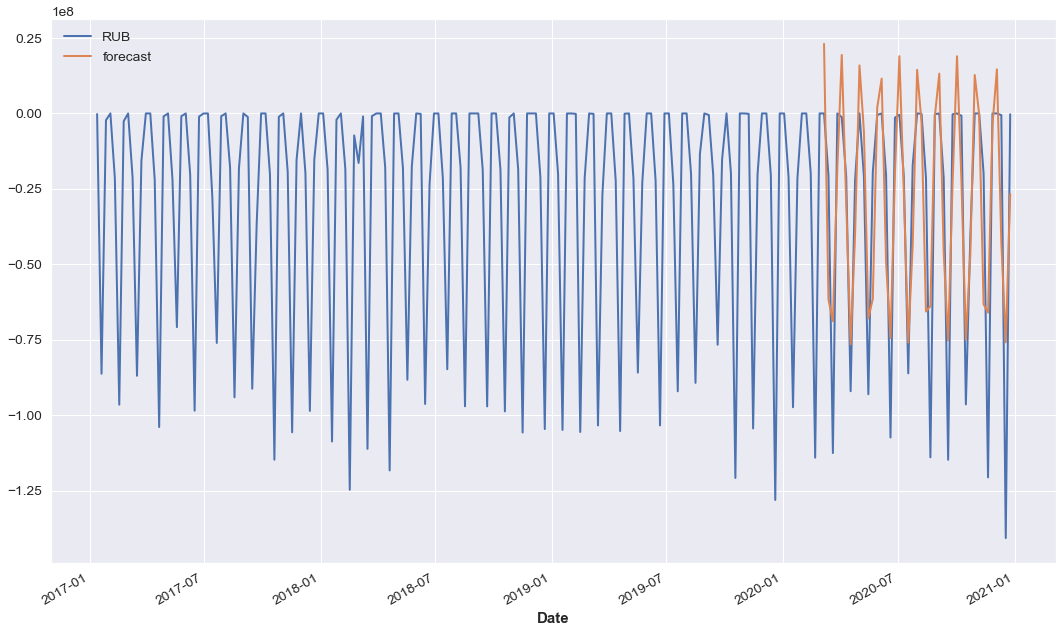

In [17]:
series_7d.plot()
prediction7d.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [18]:
mean_absolute_error(val_7d_split.pd_dataframe(), prediction7d.pd_dataframe())

22937126.129835617

In [19]:
fixed_prediction7d = prediction7d.pd_dataframe()
fixed_prediction7d[fixed_prediction7d["RUB"]>0] = 0

In [20]:
mean_absolute_error(val_7d_split.pd_dataframe(), fixed_prediction7d)

19104602.689707343

In [21]:
# 2020-03-11 - 2020-12-25
#val_1d_split.pd_dataframe() 

In [22]:
resample_fixed_prediction7d = fixed_prediction7d.resample("1D").sum()

In [27]:
# Подгонка даты
resample_fixed_prediction7d.iloc[5:]

component,RUB
Date,
2020-03-11,0.000000e+00
2020-03-12,0.000000e+00
2020-03-13,-6.162081e+07
2020-03-14,0.000000e+00
2020-03-15,0.000000e+00
...,...
2020-12-21,0.000000e+00
2020-12-22,0.000000e+00
2020-12-23,0.000000e+00


In [24]:
#fixed_prediction1d + resample_fixed_prediction7d.iloc[5:] legacy

In [28]:
val_df = pd.DataFrame()
val_df.index = resample_fixed_prediction7d.iloc[5:].index
val_df["y"] = train_3_1d.loc["2020-03-11":]
val_df["yhat"] = resample_fixed_prediction7d.iloc[5:]

<AxesSubplot:xlabel='Date'>

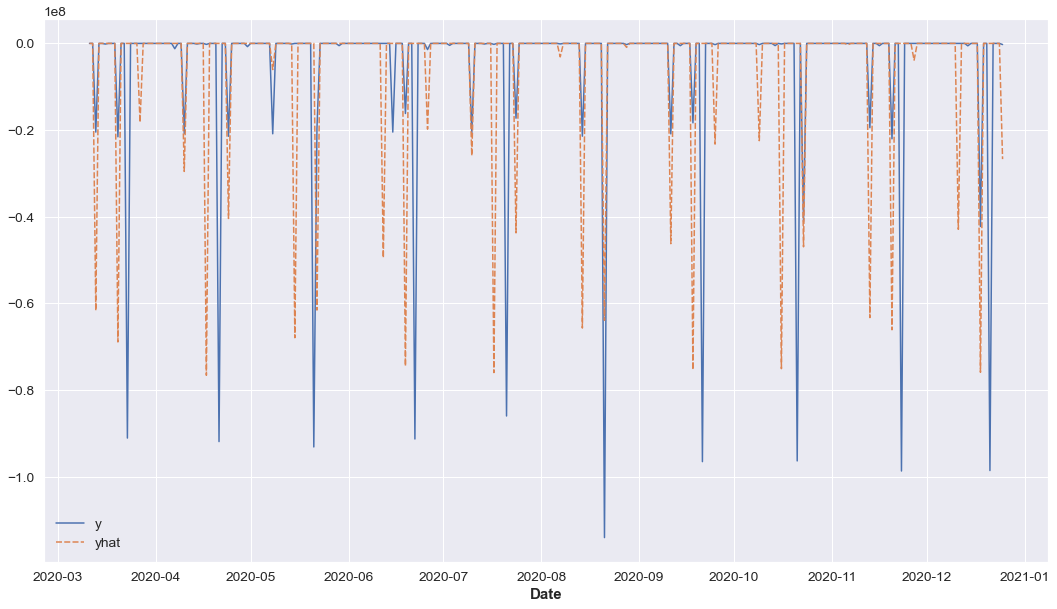

In [29]:
sns.lineplot(data=val_df)

In [30]:
model7d.fit(series_7d)
refit_prediction7d = model7d.predict(len(pd.date_range(start="2021-01-01", end="2021-06-30", freq="1D"))+1) 

In [31]:
refit_fixed_prediction7d = refit_prediction7d.pd_dataframe() # Принимаем форму стандартного датафрейма
refit_fixed_prediction7d[refit_fixed_prediction7d["RUB"]>0] = 0 # Ручная правка положительных значений

In [34]:
refit_fixed_prediction7d.resample('1D').sum().loc[:"2021-06-30"] # Проверка, что нужный диапазон записался

component,RUB
Date,
2021-01-01,0.0
2021-01-02,0.0
2021-01-03,0.0
2021-01-04,0.0
2021-01-05,0.0
...,...
2021-06-26,0.0
2021-06-27,0.0
2021-06-28,0.0


In [35]:
train_3_ans = pd.DataFrame()
#train_1_ans["Дата транзакции"] = pd.date_range(start="2021-01-05", end="2021-06-29", freq="7D") # legacy version
train_3_ans["Дата транзакции"] = pd.date_range(start="2021-01-01", end="2021-06-30", freq="1D")
train_3_ans["Сумма в RUB"] = refit_fixed_prediction7d.resample('1D').sum().loc[:"2021-06-30"].values
train_3_ans["Сумма в RUB"] = train_3_ans["Сумма в RUB"].groupby(train_3_ans["Дата транзакции"].dt.month).cumsum().values

train_3_ans["Месяц"] = train_3_ans["Дата транзакции"].dt.month
train_3_ans["БЕ"] = 3

In [36]:
train_3_ans

,Дата транзакции,Сумма в RUB,Месяц,БЕ
0,2021-01-01,0.000000e+00,1,3
1,2021-01-02,0.000000e+00,1,3
2,2021-01-03,0.000000e+00,1,3
3,2021-01-04,0.000000e+00,1,3
4,2021-01-05,0.000000e+00,1,3
...,...,...,...,...
176,2021-06-26,-1.237714e+08,6,3
177,2021-06-27,-1.237714e+08,6,3
178,2021-06-28,-1.237714e+08,6,3
179,2021-06-29,-1.237714e+08,6,3


In [37]:
train_3_ans.to_csv("train_3_ans.csv")